![data cube logo](https://static.wixstatic.com/media/8959d6_a13dc7ece5be4678af57c8f7c1667734~mv2.png/v1/fill/w_279,h_177,al_c,q_85,usm_0.66_1.00_0.01,enc_auto/VSDC_DataCubeSplash_6Partner_edited.png)
# Extraction of Flood Features from UAV RGB Imagery

 - Sign up to the [VA Datacube](https://www.data4va.org/) to run this notebook interactively from a browser
 - <b>Compatibility</b>: Notebook currently compatible with the Virginia DataCube Sandbox environments      
 - <b>Products used</b>:
    UAV imagery of Colonial Place Site A (shared/UAV_test_imagery/SiteA-RGB.tiff)
 - <b>Special requirements:</b> None
 - <b>Prerequisites:</b> None
    

## Background


An <i>optional</i> overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Australia. For Beginners_Guide or Frequently_Used_Code notebooks, this may include information about why the particular technique or approach is useful or required. If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. Dhu et al. 2017).

## Description

A <i>compulsory</i> description of the notebook, including a brief overview of how the VA data cube helps to address the problem set out above. It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we will explore the histogram of the imagery
2. Then we will try a threshold method to extract flood footprints
3. Next we will use an unsupervised classification method to extract flood footprints
4. After that we will derive flood extent lines from both methods
5. Finally we will compare the results of both methods

---------------------------------------------------------------------------------------------------------------------------

## Getting started


Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. Begin with any iPython magic commands, followed by standard Python packages, then any additional functionality you need from the Scripts directory.

In [2]:
%matplotlib inline

import sys
import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
from rasterio.enums import Resampling
from rasterio.windows import Window
from rasterio.transform import Affine
from sklearn import cluster
from osgeo import gdal, gdal_array
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.plotting import rgb

### Connect to the datacube

Connect to the datacube so we can access VA data cube data. The app parameter is a unique name for the analysis which is based on the notebook file name

In [3]:
dc = datacube.Datacube()

### Analysis parameters
An optional section to inform the user of any parameters they'll need to configure to run the notebook:
 - param_name_1: Simple description (e.g. example_value). Advice about appropriate values to choose for this parameter.
 - param_name_2: Simple description (e.g. example_value). Advice about appropriate values to choose for this parameter.

 

In [4]:
raster_path = '/home/jupyter-68bca889-0317-429c-8193d/shared/UAV_test_imagery/SiteA-RGB.tiff'
param_name_2 = 'example_value'

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 

To activate Dask, set up the local computing cluster using the cell below.

In [5]:
create_local_dask_cluster(memory_limit = '32GB')

distributed.diskutils - INFO - Found stale lock file and directory '/home/jupyter-68bca889-0317-429c-8193d/Steiner_Notebooks/va-datacube/real_world_examples/dask-worker-space/worker-gayrniv6', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/68bca889-0317-429c-aa54-ad21f6435da5/proxy/8787/status,
Dashboard: /user/68bca889-0317-429c-aa54-ad21f6435da5/proxy/8787/status,Workers: 1
Total threads: 4,Total memory: 27.01 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41833,Workers: 1
Dashboard: /user/68bca889-0317-429c-aa54-ad21f6435da5/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 27.01 GiB
Comm: tcp://127.0.0.1:38739,Total threads: 4
Dashboard: /user/68bca889-0317-429c-aa54-ad21f6435da5/proxy/33421/status,Memory: 27.01 GiB
Nanny: tcp://127.0.0.1:41369,


## Using K Means to Extract Flood Footprint


### Read in one band of the raster

Let's read in one band of the GeoTiff and normalize the data for K means and see what we get. 

In [6]:

#Try loading the raster
raster_dataset = xr.open_rasterio(raster_path, chunks=(50,50)).rename(
    {"y": "latitude", "x": "longitude"}
)

raster_dataset = (
    raster_dataset.to_dataset(dim="band")
    .rename({1: "red", 2: "green", 3: "blue"})
    .drop_vars(4)
)

#Check raster dataset
print(raster_dataset)

#raster_arrary = np.asarray(raster_dataset.geobox.resolution)



<xarray.Dataset>
Dimensions:    (latitude: 18922, longitude: 34721)
Coordinates:
  * latitude   (latitude) float64 4.084e+06 4.084e+06 ... 4.083e+06 4.083e+06
  * longitude  (longitude) float64 3.85e+05 3.85e+05 ... 3.858e+05 3.858e+05
Data variables:
    red        (latitude, longitude) uint8 dask.array<chunksize=(50, 34721), meta=np.ndarray>
    green      (latitude, longitude) uint8 dask.array<chunksize=(50, 34721), meta=np.ndarray>
    blue       (latitude, longitude) uint8 dask.array<chunksize=(50, 34721), meta=np.ndarray>
Attributes:
    transform:         (0.020730000000000002, 0.0, 385043.41551, 0.0, -0.0207...
    crs:               +init=epsg:32618
    res:               (0.020730000000000002, 0.020730000000000002)
    is_tiled:          0
    nodatavals:        (nan, nan, nan, nan)
    scales:            (1.0, 1.0, 1.0, 1.0)
    offsets:           (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:     Area
    TIFFTAG_SOFTWARE:  pix4dmapper


/tmp/ipykernel_1027694/1276447998.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  raster_dataset = xr.open_rasterio(raster_path, chunks=(50,50)).rename(


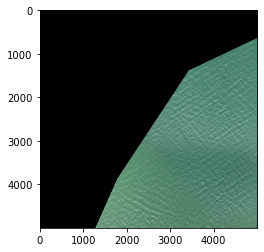

/tmp/ipykernel_1027694/1442390163.py:20: MatplotlibDeprecationWarning: 
The modification of the Axes.images property was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use Artist.remove() instead.
  del plt.gca().images[:]


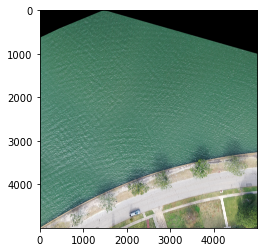

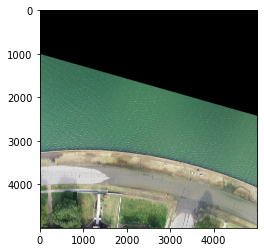

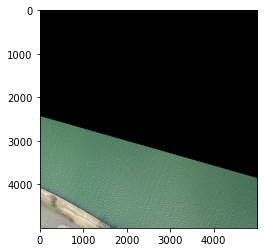

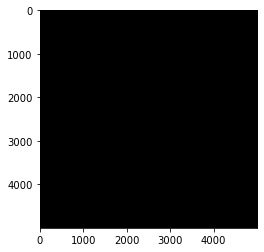

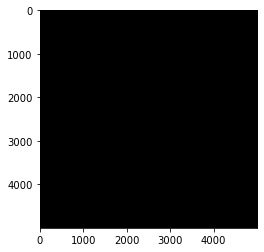

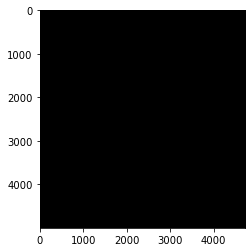

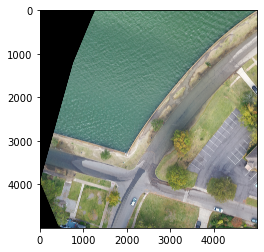

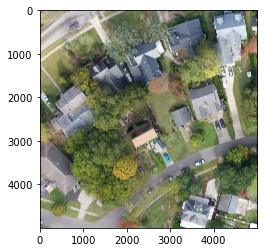

KeyboardInterrupt: 

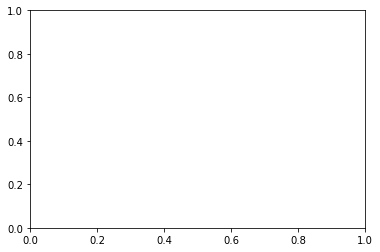

In [13]:
# set chunk size
chunk_size = 5000

# get raster dimensions
rows, cols = raster_dataset.red.shape

# plot in chunks
for r in range(0, rows, chunk_size):
    for c in range(0, cols, chunk_size):
        plt.imshow(
            np.stack([
                raster_dataset.red[r:r+chunk_size, c:c+chunk_size],
                raster_dataset.green[r:r+chunk_size, c:c+chunk_size],
                raster_dataset.blue[r:r+chunk_size, c:c+chunk_size]
            ], axis=2),
            cmap='gray'
        )
        plt.show()
        plt.close()
        del plt.gca().images[:]

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f2c38e07a20> >


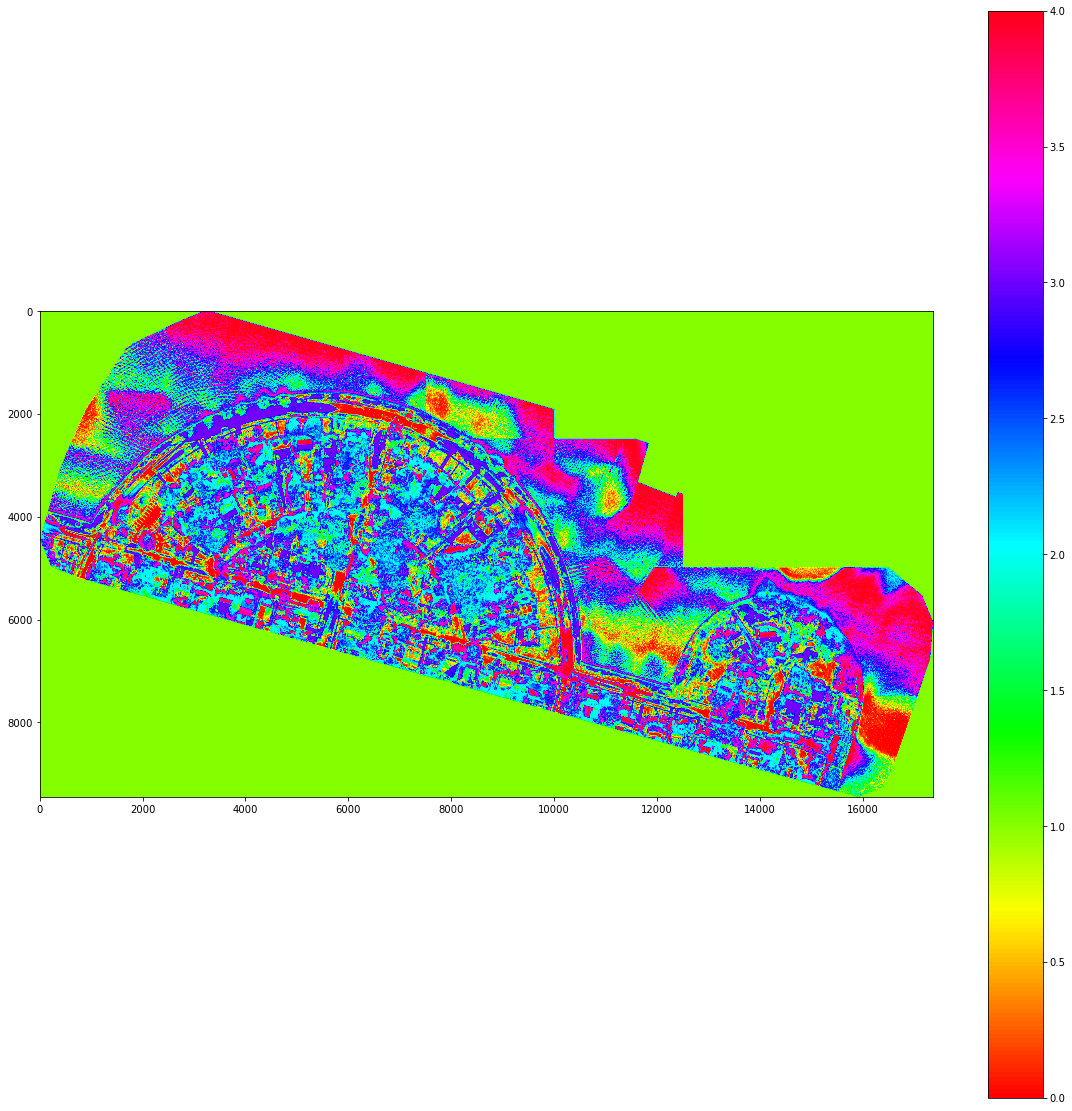

In [7]:
# Open the GeoTiff raster and extract one band

#input_raster = xr.open_rasterio(raster_path, chunks="auto")
input_raster = gdal.Open('/home/jupyter-68bca889-0317-429c-8193d/shared/UAV_test_imagery/SiteA-RGB.tiff')
print(input_raster)

band = input_raster.GetRasterBand(2)
data = band.ReadAsArray().astype(float)

# Get the original spatial resolution and calculate the new spatial resolution
original_resolution = input_raster.GetGeoTransform()[1]
new_resolution = original_resolution * 2 # Change this to the desired new resolution

# Calculate the shape of the new array
new_shape = (int(data.shape[0] / 2), int(data.shape[1] / 2))

# Reshape the data array to the new shape
new_data = np.zeros(new_shape)
for i in range(new_shape[0]):
    for j in range(new_shape[1]):
        patch = data[i*2:i*2+2, j*2:j*2+2]
        new_data[i, j] = np.nanmean(patch)

# Reshape the data array to a 1D array and remove any NaN values
reshaped_data = new_data.ravel()
reshaped_data = reshaped_data[~np.isnan(reshaped_data)]

# Apply k-means clustering to the data
num_clusters = 5 # Change this to the desired number of clusters
kmeans = cluster.KMeans(n_clusters=num_clusters)
kmeans.fit(reshaped_data.reshape(-1,1))
classified_data = kmeans.labels_.reshape(new_data.shape)

# Plot the classified image
plt.figure(figsize=(20,20))
plt.imshow(classified_data, cmap='hsv')
plt.colorbar()
plt.show()

### Read in all three bands of the raster

Here, we are going to read in all three bands of the GeoTiff and normalize the data for K means. 

## crashes likely due to inefficient read in and thus reaching the memory limit

In [9]:
# Open the source dataset and read in via chunks to save memory
raster_data = xr.open_rasterio(raster_path, chunks="auto").rename(
    {"y": "latitude", "x": "longitude"}
)

#redefine raster dataset
raster_data = (
    raster_data.to_dataset(dim="band")
    .rename({1: "red", 2: "green", 3: "blue"})
    .drop_vars(4)
)

#Check dataset
raster_data

/tmp/ipykernel_963328/356632055.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  raster_data = xr.open_rasterio(raster_path, chunks="auto").rename(


<xarray.Dataset>
Dimensions:    (latitude: 18922, longitude: 34721)
Coordinates:
  * latitude   (latitude) float64 4.084e+06 4.084e+06 ... 4.083e+06 4.083e+06
  * longitude  (longitude) float64 3.85e+05 3.85e+05 ... 3.858e+05 3.858e+05
Data variables:
    red        (latitude, longitude) uint8 dask.array<chunksize=(5792, 5792), meta=np.ndarray>
    green      (latitude, longitude) uint8 dask.array<chunksize=(5792, 5792), meta=np.ndarray>
    blue       (latitude, longitude) uint8 dask.array<chunksize=(5792, 5792), meta=np.ndarray>
Attributes:
    transform:         (0.020730000000000002, 0.0, 385043.41551, 0.0, -0.0207...
    crs:               +init=epsg:32618
    res:               (0.020730000000000002, 0.020730000000000002)
    is_tiled:          0
    nodatavals:        (nan, nan, nan, nan)
    scales:            (1.0, 1.0, 1.0, 1.0)
    offsets:           (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:     Area
    TIFFTAG_SOFTWARE:  pix4dmapper

In [ ]:
# Reshape the data into a 2D array of pixels
reshaped_data = raster_data.to_array().values.transpose(1, 2, 0).reshape(-1, 3)

# Normalize the data to have a mean of 0 and a standard deviation of 1
normalized_data = (reshaped_data - reshaped_data.mean(axis=0)) / reshaped_data.std(axis=0)

# Perform k-means clustering on the normalized data
kmeans = cluster.KMeans(n_clusters=3, random_state=0).fit(normalized_data)

# Reshape the clustered data back into a 3D array of pixels
clustered_data = kmeans.labels_.reshape(raster_data.shape[1], raster_data.shape[2])

%matplotlib inline  

# Plot the clustered data
plt.imshow(clustered_data)

## Heading 2

Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.


In [1]:
# Use code comments for low-level documentation of code
c = 3

## Additional information

<b>License:</b> The code in this notebook is licensed under the Apache License, Version 2.0. Digital Earth Australia data is licensed under the Creative Commons by Attribution 4.0 license.

<b>Contact:</b> If you need assistance, please post a question on the Open Data Cube Slack channel or on the GIS Stack Exchange using the open-data-cube tag (you can view previously asked questions here). If you would like to report an issue with this notebook, you can file one on Github.

<b>Last modified:</b> May 2020

<b>Compatible datacube version:</b>

In [ ]:
print(datacube.__version__)

## Tags 
Browse all available tags on the VA Data Cube User Guide's Tags Index 